In [79]:
import torch
import pickle
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


## Load data

As mentioned before, data are stored in HDF5 format. We need to be able to load them. This class generates a loader for us. Feel free to modify it to your needs

In [ ]:
import h5py
from torch.utils.data import Dataset

class H5Dataset(Dataset):
    def __init__(self, h5_path, transforms=None):
        self.h5_file = h5py.File(h5_path, "r")
        self.transform = transforms

    def __getitem__(self, index):
        sample = self.h5_file["data"][index]
        if self.transform is not None:
            sample = self.transform(sample)
        return (
            sample,
            int(self.h5_file["target"][index]),
        )

    def __len__(self):
        return self.h5_file["target"].size


In [36]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((180, 180), antialias=True),
        torch.nn.ReLU(inplace=True),  # remove negative values if any
        torchvision.transforms.Lambda(lambda x: torch.log(x + 1.0)),
        torchvision.transforms.Lambda(
            lambda x: x / torch.max(x) if torch.max(x) > 0 else x
        ),
    ]
)

test_data = H5Dataset("./data/test.h5")

see how many data are in this h5 file:

In [37]:
len(test_data)

51866

each case is structured like: (psd_array, target)

In [38]:
test_data[0]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 17)

How to plot for example the first image (idx=0, play with other indexes)

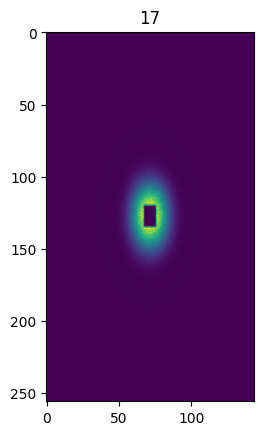

In [39]:
idx = 0
psd_array = test_data[idx][0]
target = test_data[idx][1]
plt.figure()
plt.imshow(psd_array)
plt.title(target)
plt.show()

Model is encoded in a target value. To see which model corresponds to which label, I provide this dictionary:

In [34]:
with open("model_names.pkl", "rb") as pf:
    model_names = pickle.load(pf)
print(model_names)

{0: 'Adsorbed layer', 1: 'Barbell aniso', 2: 'Bcc paracrystal aniso', 3: 'Binary hard sphere', 4: 'Broad peak', 5: 'Capped cylinder aniso', 6: 'Core shell bicelle aniso', 7: 'Core shell bicelle elliptical aniso', 8: 'Core shell bicelle elliptical belt rough aniso', 9: 'Core shell cylinder aniso', 10: 'Core shell ellipsoid aniso', 11: 'Core shell parallelepiped aniso', 12: 'Core shell sphere', 13: 'Cylinder aniso', 14: 'Dab', 15: 'Ellipsoid aniso', 16: 'Elliptical cylinder aniso', 17: 'Fcc paracrystal aniso', 18: 'Flexible cylinder', 19: 'Fractal', 20: 'Fractal core shell', 21: 'Fuzzy sphere', 22: 'Gauss lorentz gel', 23: 'Gel fit', 24: 'Hollow cylinder aniso', 25: 'Hollow rectangular prism aniso', 26: 'Lamellar hg', 27: 'Lamellar hg stack caille', 28: 'Lamellar stack paracrystal', 29: 'Mass fractal', 30: 'Mono gauss coil', 31: 'Multilayer vesicle', 32: 'Parallelepiped aniso', 33: 'Pearl necklace', 34: 'Poly gauss coil', 35: 'Polymer micelle', 36: 'Raspberry', 37: 'Rectangular prism ani

In this case, label 17 is:

In [35]:
model_names[17]

'Fcc paracrystal aniso'

### pytorch dataloader

I leave here a code template you could use to put this dataset in a dataloader for `pytorch`, which could directly go in a training loop

In [83]:
val_dataloader = DataLoader(
    test_data,
    batch_size=32, # play with this also
    num_workers=2, #modify to your cpus available!
    shuffle=True,
)

## Load instrument parameters

In [6]:
inst_params = {}
for partition in ["test", "train", "val"]:
    with open(f"inst_params_{partition}.pkl", "rb") as pf:
        inst_params[partition] = pickle.load(pf)

In [7]:
inst_params['test'].shape

torch.Size([51866, 10])

In [40]:
inst_params['test'][0]

tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 0.])

The instrument parameters of case 0 (idx=0) are:

We loaded all the instrument parameters inside the `inst_params` dictionary, with the corresponding partition as key. The 10 parameters that are one hote encoded are:

In [11]:
inst_params_names  = ['Lam_4.5', 'Lam_6.0', 'zdepth_0.001', 'zdepth_0.002', 'InstSetting_1', 'InstSetting_2', 'InstSetting_3', 'SlitSetting_1', 'SlitSetting_2', 'SlitSetting_3']
print(inst_params_names)

['Lam_4.5', 'Lam_6.0', 'zdepth_0.001', 'zdepth_0.002', 'InstSetting_1', 'InstSetting_2', 'InstSetting_3', 'SlitSetting_1', 'SlitSetting_2', 'SlitSetting_3']


- Lam = Lambda, wavelength of monochromatized neutrons in Angstroms. Two possible values [4.5, 6.0]
- zdepth = sample thickness, Two possible values [0.001, 0.002]
- InstSetting = Instrument setting. 3 possible values [1, 2, 3]
- SlitSetting = slit (collimation) setting, 3 possible values [1, 2, 3]

Again, variables are one hote encoded. Order of columns matters. This means that case 0 (described above) was measured with a wavelength of 4.5, a sample thickness of 0.001, and a slit setting of 2. (check)

This matrix can be used as **input features** for the regression or classification task.


## Model parameters - Regressor

This are the values we want to predict/estimate given an image and the model (and probably the instrument configuration) as an input.

In [12]:
model_params = {}
for partition in ["test", "train", "val"]:
    with open(f"parameters_{partition}.pkl", "rb") as pf:
        model_params[partition] = pickle.load(pf)

In [14]:
model_params['test'].shape

torch.Size([51866, 146])

The 146 different parameters are:

In [15]:
with open("parameter_names.pkl", "rb") as pf:
    model_params_names = pickle.load(pf)
    
print(model_params_names)

['sld', 'sld_solvent', 'radius', 'fuzziness', 'pd_radius', 'radius_cap', 'length', 'theta', 'phi', 'pd_radius_cap', 'pd_length', 'pd_theta', 'pd_phi', 'rg_squared', 'arms', 'pd_rg_squared', 'x_core', 'thick_rim', 'thick_face', 'sld_core', 'sld_face', 'sld_rim', 'sigma', 'Psi', 'pd_thick_rim', 'pd_thick_face', 'pd_Psi', 'dnn', 'd_factor', 'thickness', 'sld_shell', 'pd_thickness', 'ndensity', 'v_core', 'v_corona', 'sld_corona', 'radius_core', 'rg', 'd_penetration', 'n_aggreg', 'pd_radius_core', 'pd_rg', 'length_a', 'length_b', 'length_c', 'pd_length_a', 'pd_length_b', 'pd_length_c', 'volfraction', 'thick_shell', 'thick_solvent', 'n_shells', 'pd_thick_shell', 'pd_thick_solvent', 'length_tail', 'length_head', 'sld_head', 'pd_length_tail', 'pd_length_head', 'second_moment', 'adsorbed_amount', 'density_shell', 'fractal_dim', 'cor_length', 'pd_cor_length', 'fractal_dim_mass', 'cutoff_length', 'pd_cutoff_length', 'radius_polar', 'radius_equatorial', 'pd_radius_polar', 'pd_radius_equatorial', '

This is the set of all model parameters for all models. It's a sparce matrix, because all SANS models have less than 25 parameters.

In [42]:
# check case 0
idx = 0
model_params['test'][idx]

tensor([0.2744, 0.3041, 0.0089, 0.0000, 0.0760, 0.0000, 0.0000, 0.8110, 0.3488,
        0.0000, 0.0000, 0.5400, 0.6140, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4780, 0.0000, 0.0000, 0.6200,
        0.9476, 0.5084, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

To check which are the corresponding parameters of this simulation, you can use the masks array as follows (selects parameters for corresponding model)

In [19]:
with open("sasmodel_masks.pkl", "rb") as pf:
    masks = pickle.load(pf)

In [22]:
# 46 masks for the 146 parameters
masks.shape

torch.Size([46, 146])

In [48]:
target_idx = test_data[idx][1]
print(model_names[target_idx])

Fcc paracrystal aniso


In [74]:
# mask selecting parameters for this model
current_mask = masks[target_idx]

def get_parameter_names_from_mask(model_params_names, mask):
    return [mi for mi, keep in zip(model_params_names, mask) if not keep]
print(get_parameter_names_from_mask(model_params_names, current_mask))

['sld', 'sld_solvent', 'radius', 'pd_radius', 'theta', 'phi', 'pd_theta', 'pd_phi', 'Psi', 'pd_Psi', 'dnn', 'd_factor']


Check [here for fcc documentation](https://www.sasview.org/docs/user/models/fcc_paracrystal.html). 

There are extra parameters that start with pd (polidispersity), and there are no scale or background parameters since the images ar normalized minmax.

Therefore, parameters for this model would be:

In [76]:
model_params['test'][idx][~current_mask]

tensor([0.2744, 0.3041, 0.0089, 0.0760, 0.8110, 0.3488, 0.5400, 0.6140, 0.4780,
        0.6200, 0.9476, 0.5084])

The mask is set to true for thos values that should be masked, so you want to keep the opposite to the mask `~current_mask`.

With this you have the basics to load data, and also access the metadata. Classification and regression problems, as well as generative modelling can be established.

For questions, write me at j.robledo@fz-juelich.de